# YAASS Dataset

### The dataset below includes demographic information and multiple clinical measures taken in 4 populations: healthy controls, those at clinical high risk for psychosis, those at familial high risk, and those diagnosed with schizophrenia.

In [1]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Expts/YAASS/Data/'
path2analysis = '/Users/' + uname + '/Work/Expts/YAASS/Analysis/'
path2figs = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/Figures/'

In [2]:
%cd {path2code}

import csv, misc, os, random, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy.stats import zscore
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R suppressMessages(library('lmerTest'))
%R suppressMessages(library('lsmeans'))
%R lsm.options(disable.pbkrtest=TRUE)
%R suppressMessages(library('effsize')) # Can use this to estimate Cohen's d
%R suppressMessages(library('afex'))
%R suppressMessages(library('QuantPsyc')) #helpful for extracting betas from hierarchical regresssions
%R suppressMessages(library('vcd')) # useful for getting effect sizes from chi-square tests
%R suppressMessages(library('scales'))

/Users/ebarrick/Work/Expts/Code


array(['scales', 'vcd', 'grid', 'QuantPsyc', 'MASS', 'boot', 'afex',
       'reshape2', 'effsize', 'lsmeans', 'estimability', 'lmerTest',
       'lme4', 'Matrix', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], 
      dtype='|S12')

### Building the dataframe

In [38]:
#Function to assign names to disorders column
# def dx_name(data):
#     d = {0:'None', 1:'MDD', 2:'Anxiety', 3:'Sub_abuse', 4:'ADHD', 
#          5:'Eating', 6:'Schizotypal', 7:'2_co', 8: '3_co', 9:'4_co','999':'na'}
#     dx = d[data]
#     return dx 

In [31]:
# """YAASS data: CHR and HC"""
# raw_chr = pd.read_excel(path2data + 'Bx_Paper_YAASS_Feb2017_edit.xlsx')
# raw_chr['Gender'].replace(2, 'female', inplace=True)
# raw_chr['Gender'].replace(1,'male', inplace=True)

# #individual IRI scores
# raw_iri_Y = pd.read_excel(path2data + 'YAASS_IRI.xlsx', sheetname='IRI_EB')
# raw_iri_Y = raw_iri_Y.rename(columns={"Subject": "ID"})

# #rescaling the IRI scores from the individual data
# new = {1: 1, 2: 1.8, 3: 2.6, 4: 3.4, 5: 4.2, 6: 5} 
# Y = raw_iri_Y.applymap(lambda d: new.get(d) if d in new else d)
# Y.reindex()

# #Getting the total for each IRI subscale
# fs = ['1_FS', '5_FS', '7_FS_R', '12_FS_R', '16_FS', '23_FS', '26_FS']
# ec = ['2_EC', '4_EC_R', '9_EC', '14_EC_R', '18_EC_R', '20_EC', '22_EC']
# pt = ['3_PT_R', '8_PT', '11_PT', '15_PT_R', '21_PT', '25_PT', '28_PT']
# pd = ['6_PD', '10_PD', '13_PD_R', '17_PD', '19_PD_R', '24_PD', '27_PD']

# Y['IRI_FS_total'] = Y[fs].sum(axis=1)
# Y['IRI_EC_total'] = Y[ec].sum(axis=1)
# Y['IRI_PT_total'] = Y[pt].sum(axis=1)
# Y['IRI_PD_total'] = Y[pd].sum(axis=1)

# Y = Y[['ID','IRI_FS_total','IRI_EC_total','IRI_PT_total','IRI_PD_total']].copy()

In [32]:
# merge new IRI scores with YAASS data
# y = raw_chr.merge(Y, on='ID', how='left')

In [39]:
# """SCORE data: SZ and HC"""
# raw_sz = pd.read_excel(path2data + 'SCORE Data_Bx_IRI_SocialFx.xlsx')
# raw_sz['Group'].replace(2, 'SZ', inplace=True)
# raw_sz['Group'].replace(1,'HC',inplace=True)
# raw_sz['Gender'].replace(1,'male',inplace=True)
# raw_sz['Gender'].replace(2,'female',inplace=True)

# #individual IRI scores
# raw_iri_S = pd.read_excel(path2data + 'IRI_DAS_CERQ_SCORE.xlsx', sheetname='IRI_EB')
# raw_iri_S = raw_iri_S.rename(columns={"Subject": "ID"})

# #rescaling the IRI scores from the individual data
# new = {1: 1, 2: 1.8, 3: 2.6, 4: 3.4, 5: 4.2, 6: 5} 
# S = raw_iri_S.applymap(lambda d: new.get(d) if d in new else d)
# S.reindex()

# #Getting the total for each IRI subscale
# fs = ['1_FS', '5_FS', '7_FS_R', '12_FS_R', '16_FS', '23_FS', '26_FS']
# ec = ['2_EC', '4_EC_R', '9_EC', '14_EC_R', '18_EC_R', '20_EC', '22_EC']
# pt = ['3_PT_R', '8_PT', '11_PT', '15_PT_R', '21_PT', '25_PT', '28_PT']
# pd = ['6_PD', '10_PD', '13_PD_R', '17_PD', '19_PD_R', '24_PD', '27_PD']

# S['IRI_FS_total'] = S[fs].sum(axis=1)
# S['IRI_EC_total'] = S[ec].sum(axis=1)
# S['IRI_PT_total'] = S[pt].sum(axis=1)
# S['IRI_PD_total'] = S[pd].sum(axis=1)

# S = S[['ID','IRI_FS_total','IRI_EC_total','IRI_PT_total','IRI_PD_total']].copy()

In [40]:
#merge new IRI scores with SCORE data
# s = raw_sz.merge(, on='ID', how='left')

In [43]:
# """FAME data: FHR"""

# raw_fhr = pd.read_excel(path2data + 'FAME_Neuropsych_NEW_edit.xlsx')
# raw_fhr['Group'].replace(1, 'FHR', inplace=True)
# raw_fhr['Gender'].replace(2, 'female', inplace=True)
# raw_fhr['Gender'].replace(1,'male', inplace=True)
# raw_fhr = raw_fhr.rename(columns={"IRI_PT": "IRI_PT_total", "IRI_EC": "IRI_EC_total", "IRI_PD": "IRI_PD_total", 
#                                   "IRI_FS": "IRI_FS_total"})

In [56]:
# g = pd.concat([raw_fhr, s])

In [3]:
# raw = pd.concat([g,y])
# pd.set_option('display.max_columns', 500)
# raw.tail()

In [61]:
# output to csv
# raw.to_csv('raw.csv')

In [4]:
raw = pd.read_csv(path2data + 'raw.csv')

In [5]:
raw.head()

,ID,Group,Gender,Age,Education,Ethnicity,IQ,DSMDisorder,DSMDisorderType,DSMcomorbidities,...,PANAS_PA,SIPS_Disorganized,SIPS_General,SIPS_Negative,SIPS_Positive,SocAdjScale_SocialLeisure,SocAdjScale_Work,GFS_Role,GFS_Social,Present_Clinical
0,2501,FHR,female,25,14.0,NaN,99.0,1.0,7.0,2.0,...,NaN,0.75,0.75,0.500000,1.4,NaN,NaN,NaN,NaN,1.0
1,2504,FHR,female,29,16.0,NaN,118.0,1.0,7.0,2.0,...,NaN,0.50,0.50,0.333333,1.0,38.0,51.0,NaN,NaN,1.0
2,2505,FHR,male,33,14.0,NaN,95.0,0.0,0.0,0.0,...,NaN,0.25,0.00,0.000000,0.4,51.0,58.0,NaN,NaN,0.0
3,2506,FHR,male,33,13.0,NaN,109.0,1.0,4.0,1.0,...,NaN,1.00,0.75,1.166667,1.2,49.0,55.0,NaN,NaN,1.0
4,2508,FHR,male,28,16.0,NaN,118.0,0.0,NaN,0.0,...,NaN,1.25,1.00,0.500000,1.4,40.0,64.0,NaN,NaN,0.0


### Demographics

In [6]:
print ('Total Group Count')
raw.groupby('Group')['ID'].nunique()

Total Group Count


Group
CHR    27
FHR    19
HC     38
SZ     26
Name: ID, dtype: int64

In [7]:
#Even split in HC group, more males in HR and SZ group - unsurprising...
#however mostly female in GHR group
print ('Gender by Group')
raw.groupby('Group')['Gender'].value_counts()

Gender by Group


Group  Gender
CHR    male      18
       female     9
FHR    female    14
       male       5
HC     male      22
       female    16
SZ     male      16
       female    10
Name: Gender, dtype: int64

Age by Group
Group       
CHR    count    27.000000
       mean     21.629630
       std       4.404090
       min      15.000000
       25%      18.000000
       50%      22.000000
       75%      23.500000
       max      34.000000
FHR    count    19.000000
       mean     27.421053
       std       3.920258
       min      20.000000
       25%      24.500000
       50%      27.000000
       75%      31.000000
       max      33.000000
HC     count    38.000000
       mean     29.763158
       std      11.769025
       min      18.000000
       25%      21.000000
       50%      24.000000
       75%      41.500000
       max      55.000000
SZ     count    26.000000
       mean     38.692308
       std      10.279180
       min      21.000000
       25%      31.250000
       50%      38.500000
       75%      44.750000
       max      58.000000
Name: Age, dtype: float64


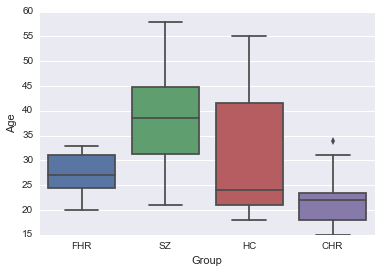

In [8]:
print ('Age by Group')
g=raw.groupby('Group')
print (g.Age.describe())

sns.boxplot(x='Group',y='Age',data=raw)

In [12]:
"""Dataframe dropping participants without an IQ value"""
raw_IQ = raw[np.isfinite(raw['IQ'])]

Group
CHR    106.791667
FHR    117.000000
HC     112.105263
SZ     108.076923
Name: IQ, dtype: float64
Group
CHR    17.688068
FHR     9.779931
HC     11.668367
SZ     13.323432
Name: IQ, dtype: float64
ANOVA for IQ x Group


             Df Sum Sq Mean Sq F value Pr(>F)  
Group         3   1335   444.9    2.48 0.0653 .
Residuals   102  18297   179.4                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


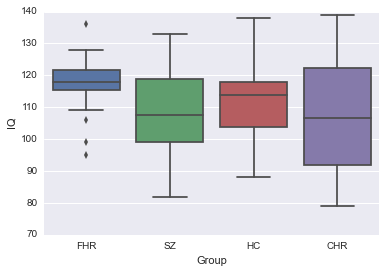

In [34]:
i = raw_IQ.groupby('Group')

print (i.IQ.mean())
print (i.IQ.std())

sns.boxplot(x='Group',y='IQ',data=raw_IQ)

print ('ANOVA for IQ x Group')
%R iq2.aov <- aov(IQ ~ Group, data=raw_IQ)
%R print (summary(iq2.aov))

### Looking at Measures

IRI_EC Mean
Group
CHR    22.338462
FHR    20.333333
HC     25.589474
SZ     24.853846
Name: IRI_EC_total, dtype: float64
IRI_FS Mean
Group
CHR    22.153846
FHR    15.166667
HC     19.568421
SZ     22.453846
Name: IRI_FS_total, dtype: float64
IRI_PD Mean
Group
CHR    17.784615
FHR     8.833333
HC     13.589474
SZ     16.053846
Name: IRI_PD_total, dtype: float64
IRI_PT Mean
Group
CHR    21.807692
FHR    21.500000
HC     24.978947
SZ     24.453846
Name: IRI_PT_total, dtype: float64


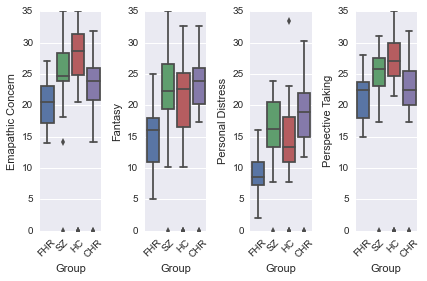

In [73]:
#SCORE and YAASS scored on 5-pt scale, FAME on 6-pt scale. Transformed to z scores.
#FHR scores seem much lower than the other groups...

print('IRI_EC Mean')
print(g.IRI_EC_total.mean())
print('IRI_FS Mean')
print(g.IRI_FS_total.mean())
print('IRI_PD Mean')
print(g.IRI_PD_total.mean())
print('IRI_PT Mean')
print(g.IRI_PT_total.mean())

fig = plt.figure()
iri = fig.add_subplot(141)
sns.boxplot(y='IRI_EC_total', x='Group', data = raw)
plt.ylabel('Emapathic Concern')
plt.xticks(rotation=45)
iri = fig.add_subplot(142)
sns.boxplot(y='IRI_FS_total', x='Group', data = raw)
plt.ylabel('Fantasy')
plt.xticks(rotation=45)
iri = fig.add_subplot(143)
sns.boxplot(y='IRI_PD_total', x='Group', data = raw)
plt.ylabel('Personal Distress')
plt.xticks(rotation=45)
iri = fig.add_subplot(144)
sns.boxplot(y='IRI_PT_total', x='Group', data = raw)
plt.ylabel('Perspective Taking')
plt.xticks(rotation=45)
fig.tight_layout()

#### Clear difference in prodromal psychotic sympoms between high risk groups. This could account for the split on IRI scubscales into CHR/SZ and FHR/HC. Both the FHR and CHR group have DSM diagnoses, and at least some FHR participants were experiencing depressed or anxious symptoms at time of testing (check on whether we have that info for CHR). This could mean that having symptoms on the psychotic spectrum, regardless of meeting clinical diagnosis, would put you at risk for social deficits above and beyond other DSM diagnoses. Will test below.

* Need to remove N1 from negative symptoms if statistically testing (measures social functioning)

Between-group t-tests on SIPS General: Risk Groups
t(44) = -4.77, p = 0.000, g = -1.469


  Effect    df  MSE         F ges p.value
1  Group 2, 65 6.81 21.95 *** .40  <.0001


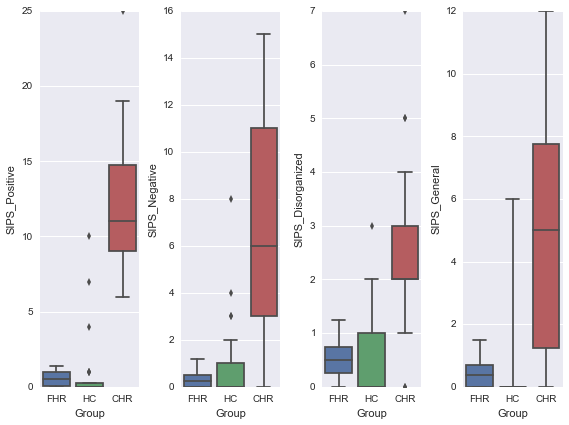

In [22]:
sips = raw[~(raw.Group == 'SZ')]

fig = plt.figure(figsize=(8, 6))
si = fig.add_subplot(141)
sns.boxplot(y='SIPS_Positive', x='Group', data = sips)
si = fig.add_subplot(142)
sns.boxplot(y='SIPS_Negative', x='Group', data = sips)
si = fig.add_subplot(143)
sns.boxplot(y='SIPS_Disorganized', x='Group', data = sips)
si = fig.add_subplot(144)
sns.boxplot(y='SIPS_General', x='Group', data = sips)
fig.tight_layout()

print ('Between-group t-tests on SIPS General: Risk Groups')
misc.ttest_2s(raw[raw.Group == 'FHR']['SIPS_General'],raw[raw.Group == 'CHR']['SIPS_General'])

%Rpush raw
%R SIPS.aov <- aov_ez(dv='SIPS_General', id='ID', between='Group',data=raw)
%R print (SIPS.aov)

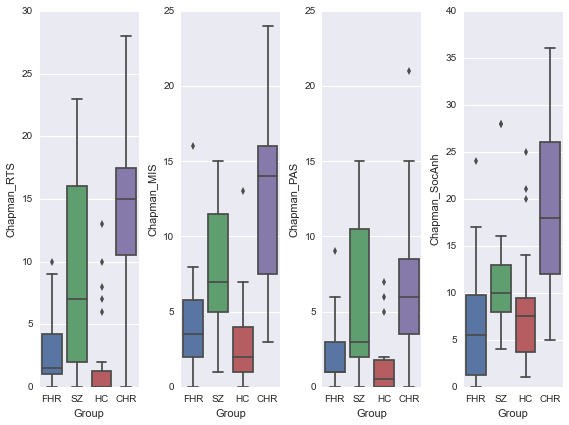

In [24]:
fig = plt.figure(figsize=(8, 6))
chap = fig.add_subplot(141)
sns.boxplot(y='Chapman_RTS', x='Group', data = raw)
chap = fig.add_subplot(142)
sns.boxplot(y='Chapman_MIS', x='Group', data = raw)
chap = fig.add_subplot(143)
sns.boxplot(y='Chapman_PAS', x='Group', data = raw)
chap = fig.add_subplot(144)
sns.boxplot(y='Chapman_SocAnh', x='Group', data = raw)
fig.tight_layout()

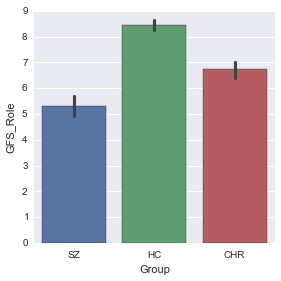

In [25]:
# no measures from FAME
gfs = raw[~(raw.Group == 'FHR')]

sns.factorplot(y='GFS_Role',x='Group',units='ID',ci=68,kind='bar',data=gfs)

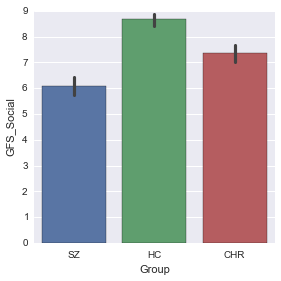

In [26]:
#No measures from FAME
sns.factorplot(y='GFS_Social',x='Group',units='ID',ci=68,kind='bar',data=gfs)

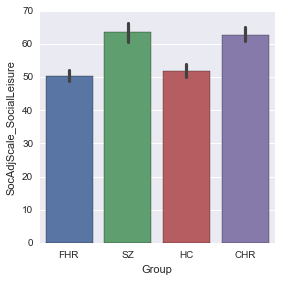

In [27]:
sns.factorplot(y='SocAdjScale_SocialLeisure',x='Group',units='ID',ci=68,kind='bar',data=raw)

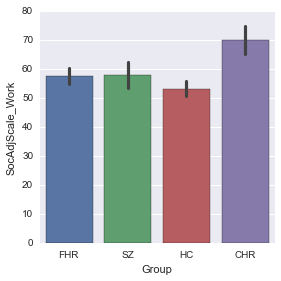

In [28]:
sns.factorplot(y='SocAdjScale_Work',x='Group',units='ID',ci=68,kind='bar',data=raw)

### IRI and SAS

In [30]:
%Rpush raw
%R str(raw)

'data.frame':	110 obs. of  31 variables:
 $ ID                       : int  2501 2504 2505 2506 2508 2509 2510 2511 2513 2515 ...
 $ Group                    : Factor w/ 4 levels "CHR","FHR","HC",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Gender                   : Factor w/ 2 levels "female","male": 1 1 2 2 2 1 1 1 1 1 ...
 $ Age                      : int  25 29 33 33 28 25 30 32 27 27 ...
 $ Education                : num  14 16 14 13 16 17 18 15 19 16 ...
 $ Ethnicity                : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ IQ                       : num  99 118 95 109 118 121 123 128 122 118 ...
 $ DSMDisorder              : num  1 1 0 1 0 1 1 1 1 1 ...
 $ DSMDisorderType          : num  7 7 0 4 NaN 2 8 7 7 8 ...
 $ DSMcomorbidities         : num  2 2 0 1 0 1 3 2 2 3 ...
 $ IRI_EC_total             : num  NaN 21 21 14 18 26 22 16 20 25 ...
 $ IRI_FS_total             : num  NaN 6 19 15 16 18 16 17 10 18 ...
 $ IRI_PD_total             : num  NaN 6 5 9 16 11 8 13 8 11 ...
 $ IRI_PT

In [31]:
print ('ANOVA on SAS Social Leisure x Group')
%R sas_sl.aov <- aov_ez(dv='SocAdjScale_SocialLeisure', id='ID', between='Group',data=raw)
%R print (sas_sl.aov)

print ('ANOVA on SAS Work x Group')
%R sas_w.aov <- aov_ez(dv='SocAdjScale_Work', id='ID', between ='Group',data=raw)
%R print (sas_w.aov)

ANOVA on SAS Social Leisure x Group


  Effect    df    MSE        F ges p.value
1  Group 3, 93 132.70 8.68 *** .22  <.0001


ANOVA on SAS Work x Group


  Effect    df    MSE      F ges p.value
1  Group 3, 93 389.08 3.34 * .10     .02


In [32]:
print ('ANOVA for IRI_EC x Group')
%R iri_ec <- aov(IRI_EC_total ~ Group,data=raw)
%R print (summary(iri_ec))
print ('ANOVA for IRI_PD x Group')
%R iri_pd <- aov(IRI_PD_total ~ Group,data=raw)
%R print (summary(iri_pd))
print ('ANOVA for IRI_PT x Group')
%R iri_pt <- aov(IRI_PT_total ~ Group,data=raw)
%R print (summary(iri_pt))
print ('ANOVA for IRI_FS x Group')
%R iri_fs <- aov(IRI_FS_total ~ Group,data=raw)
%R print (summary(iri_fs))

ANOVA for IRI_EC x Group


             Df Sum Sq Mean Sq F value Pr(>F)  
Group         3    422  140.73   2.306 0.0811 .
Residuals   104   6348   61.04                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
2 observations deleted due to missingness


ANOVA for IRI_PD x Group


             Df Sum Sq Mean Sq F value   Pr(>F)    
Group         3    952   317.2   8.372 4.89e-05 ***
Residuals   104   3941    37.9                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
2 observations deleted due to missingness


ANOVA for IRI_PT x Group


             Df Sum Sq Mean Sq F value Pr(>F)
Group         3    253   84.41   1.514  0.215
Residuals   104   5798   55.75               
2 observations deleted due to missingness


ANOVA for IRI_FS x Group


             Df Sum Sq Mean Sq F value  Pr(>F)   
Group         3    702  234.09   4.094 0.00862 **
Residuals   104   5946   57.17                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
2 observations deleted due to missingness


             Df Sum Sq Mean Sq F value   Pr(>F)    
IRI_EC_total  1    364   364.5   2.764   0.0998 .  
Group         3   3301  1100.3   8.345 5.76e-05 ***
Residuals    92  12130   131.8                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


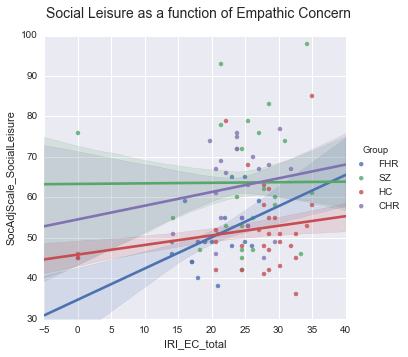

In [59]:
%R iri_ec_sl <- aov(SocAdjScale_SocialLeisure ~ IRI_EC_total + Group,data=raw)
%R print (summary(iri_ec_sl))

g = sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_EC_total',hue='Group',
           units='ID',ci=68,data=raw)
g = sns.plt.ylim(30,100)
plt.subplots_adjust(top=0.9)
sns.plt.suptitle('Social Leisure as a function of Empathic Concern', fontsize=14)

In [36]:
%R group.fm <- lm(SocAdjScale_SocialLeisure ~ Group + (1|ID), data=raw)
%R ec.fm <- lm(SocAdjScale_SocialLeisure ~ Group + IRI_EC_total + (1|ID), data=raw)

%R ec.aov <- anova(group.fm, ec.fm)
%R print(ec.aov)
# %R print(summary(pd.fm3))

Analysis of Variance Table

Model 1: SocAdjScale_SocialLeisure ~ Group + (1 | ID)
Model 2: SocAdjScale_SocialLeisure ~ Group + IRI_EC_total + (1 | ID)
  Res.Df   RSS Df Sum of Sq      F Pr(>F)
1     93 12342                           
2     92 12130  1    211.55 1.6045 0.2085


                                         Df Sum Sq Mean Sq F value   Pr(>F)    
as.factor(Group)                          3   3454  1151.3   7.335 0.000479 ***
as.factor(IRI_PD_total)                  34   3480   102.3   0.652 0.898196    
as.factor(Group):as.factor(IRI_PD_total) 18   2426   134.8   0.859 0.625939    
Residuals                                41   6435   157.0                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


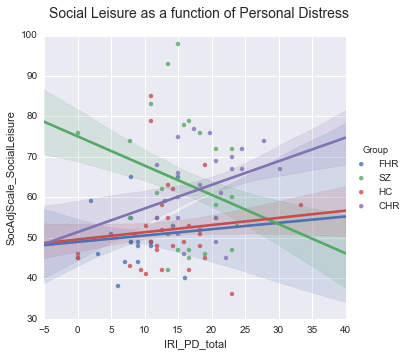

In [60]:
%R iri_pd_sl <- aov(SocAdjScale_SocialLeisure ~ as.factor(Group)*as.factor(IRI_PD_total),data=raw)
%R print (summary(iri_pd_sl))

sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_PD_total',hue='Group',
           units='ID',ci=68,data=raw)
sns.plt.ylim(30,100)
plt.subplots_adjust(top=0.9)
sns.plt.suptitle('Social Leisure as a function of Personal Distress', fontsize=14)

In [37]:
%R pd.fm1 <- lm(SocAdjScale_SocialLeisure ~  Group + (1|ID), data=raw)
%R pd.fm2 <- lm(SocAdjScale_SocialLeisure ~  Group + IRI_PD_total + (1|ID), data=raw)

%R pd_fm.aov <- anova(pd.fm1, pd.fm2)
%R print(pd_fm.aov)

Analysis of Variance Table

Model 1: SocAdjScale_SocialLeisure ~ Group + (1 | ID)
Model 2: SocAdjScale_SocialLeisure ~ Group + IRI_PD_total + (1 | ID)
  Res.Df   RSS Df Sum of Sq      F Pr(>F)
1     93 12342                           
2     92 12341  1   0.36355 0.0027 0.9586


                                         Df Sum Sq Mean Sq F value   Pr(>F)    
as.factor(Group)                          3   3454  1151.3   10.26 3.42e-05 ***
as.factor(IRI_PT_total)                  29   4296   148.1    1.32    0.202    
as.factor(Group):as.factor(IRI_PT_total) 22   3332   151.5    1.35    0.198    
Residuals                                42   4714   112.2                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


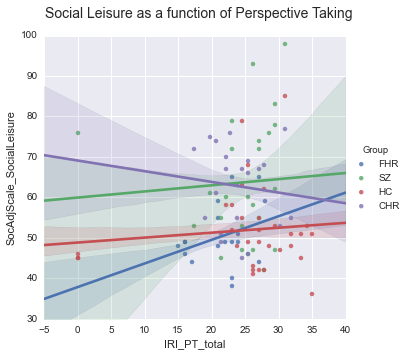

In [61]:
%R iri_pt_sl <- aov(SocAdjScale_SocialLeisure ~ as.factor(Group)*as.factor(IRI_PT_total),data=raw)
%R print (summary(iri_pt_sl))

sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_PT_total',hue='Group',
           units='ID',ci=68,data=raw)
sns.plt.ylim(30,100)
plt.subplots_adjust(top=0.9)
sns.plt.suptitle('Social Leisure as a function of Perspective Taking', fontsize=14)

In [38]:
%R pt.fm1 <- lm(SocAdjScale_SocialLeisure ~  Group + (1|ID), data=raw)
%R pt.fm2 <- lm(SocAdjScale_SocialLeisure ~  Group + IRI_PT_total + (1|ID), data=raw)

%R pt_fm.aov <- anova(pt.fm1, pt.fm2)
%R print(pt_fm.aov)

Analysis of Variance Table

Model 1: SocAdjScale_SocialLeisure ~ Group + (1 | ID)
Model 2: SocAdjScale_SocialLeisure ~ Group + IRI_PT_total + (1 | ID)
  Res.Df   RSS Df Sum of Sq      F Pr(>F)
1     93 12342                           
2     92 12272  1    68.952 0.5169  0.474


                                         Df Sum Sq Mean Sq F value   Pr(>F)    
as.factor(Group)                          3   3454  1151.3  11.727 1.52e-05 ***
as.factor(IRI_FS_total)                  36   5389   149.7   1.525   0.1032    
as.factor(Group):as.factor(IRI_FS_total) 20   3320   166.0   1.691   0.0817 .  
Residuals                                37   3632    98.2                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


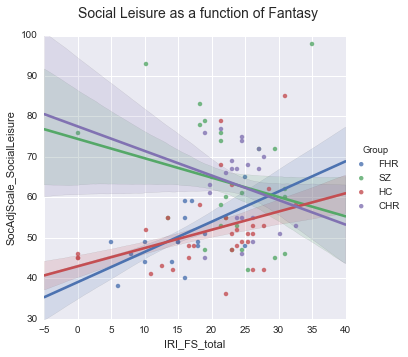

In [62]:
%R iri_fs_sl <- aov(SocAdjScale_SocialLeisure ~ as.factor(Group)*as.factor(IRI_FS_total),data=raw)
%R print (summary(iri_fs_sl))

sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_FS_total',hue='Group',
           units='ID',ci=68,data=raw)
sns.plt.ylim(30,100)
plt.subplots_adjust(top=0.9)
sns.plt.suptitle('Social Leisure as a function of Fantasy', fontsize=14)

In [39]:
%R fs.fm1 <- lm(SocAdjScale_SocialLeisure ~  Group + (1|ID), data=raw)
%R fs.fm2 <- lm(SocAdjScale_SocialLeisure ~  Group + IRI_FS_total + (1|ID), data=raw)

%R fs_fm.aov <- anova(fs.fm1, fs.fm2)
%R print(fs_fm.aov)

Analysis of Variance Table

Model 1: SocAdjScale_SocialLeisure ~ Group + (1 | ID)
Model 2: SocAdjScale_SocialLeisure ~ Group + IRI_FS_total + (1 | ID)
  Res.Df   RSS Df Sum of Sq      F Pr(>F)
1     93 12342                           
2     92 12244  1    97.596 0.7333  0.394
